In [3]:
import itertools
import pandas as pd
import glob
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import scale
from sklearn import mixture
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(777)

total_df = pd.read_csv("to_mrmr.csv")



window_size = 2
normal_scores = []
feature = ['flux',
           'zero_month',
           'zero_week',
           'continuous_zero',
           'diff_week_day',
           'diff_month',
           'std_week',
           'diff_std',
           'rec_day',
           'rec_week',
           'rec_2week',
           'rec_month',
           'rec_day2',
           'rec_week2',
           'rec_2week2',
           'rec_month2', ]


df = total_df.dropna(axis=0)

normal = df[df['label']==0]
abnormal = df[df['label']==1]

random_idx_normal = np.arange(normal.shape[0])
np.random.shuffle(random_idx_normal)

random_idx_abnormal = np.arange(abnormal.shape[0])
np.random.shuffle(random_idx_abnormal)

train_x = normal.loc[:, feature].iloc[random_idx_normal[:normal.shape[0]*2//10]]
train_y = [[1,0] for _ in range(train_x.shape[0])]

print(train_x.shape)

for i in range(200):
  train_x = train_x.append(abnormal.loc[:,feature].iloc[random_idx_abnormal[:abnormal.shape[0]//2]])
  train_y += [[0, 1] for _ in range(abnormal.shape[0]//2)]

print(train_x.shape)
  
train_x = train_x.to_numpy()
train_y = np.array(train_y)




#assert(False)
#test_x = normal.loc[:, feature].sample(frac=0.2)\
#                 .append(abnormal.loc[:,feature].iloc[abnormal.shape[0]//2:]).to_numpy()

test_x = normal.loc[:, feature].iloc[random_idx_normal[normal.shape[0]//2:]]
test_y = [[1,0] for _ in range(test_x.shape[0])]


for i in range(1):
  test_x = test_x.append(abnormal.loc[:,feature].iloc[random_idx_abnormal[abnormal.shape[0]//2:]])
  test_y += [[0, 1] for _ in range(abnormal.shape[0] - abnormal.shape[0]//2)]

test_x = test_x.to_numpy()
test_y = np.array(test_y)

def get_data():
    global train_x, train_y
    random_idx = np.arange(train_x.shape[0])
    np.random.shuffle(random_idx)
    train_x = train_x[random_idx]
    train_y = train_y[random_idx]
    for i in range(train_x.shape[0]):
      x = train_x[i].astype(np.float32)
      y = train_y[i].astype(np.int8)
      yield (x, y)

training_set = tf.data.Dataset.from_generator(get_data, (tf.float32, np.int8), ((len(feature),), (2,)))

training_set = training_set.batch(256)

def get_test_data():
    global test_x, test_y
    for i in range(test_x.shape[0]):
      x = test_x[i].astype(np.float32)
      y = test_y[i].astype(np.int8)
      yield (x, y)

test_set = tf.data.Dataset.from_generator(get_test_data, (tf.float32, np.int8), ((len(feature),), (2,)))

test_set = test_set.batch(256)


(571122, 16)
(668922, 16)


In [6]:
print(train_x.shape)
print(train_y.shape)

(1550057, 16)
(1550057, 2)


l2param = 0.03
Epoch 1/10
2613/2613 [==============================] - 40s 15ms/step - loss: 0.4942 - accuracy: 0.9310
Epoch 2/10
2613/2613 [==============================] - 36s 14ms/step - loss: 0.3249 - accuracy: 0.9568
Epoch 3/10
2613/2613 [==============================] - 36s 14ms/step - loss: 0.3248 - accuracy: 0.9569
Epoch 4/10
2613/2613 [==============================] - 36s 14ms/step - loss: 0.3247 - accuracy: 0.9569
Epoch 5/10
2613/2613 [==============================] - 37s 14ms/step - loss: 0.3246 - accuracy: 0.9568
Epoch 6/10
2613/2613 [==============================] - 38s 15ms/step - loss: 0.3245 - accuracy: 0.9569
Epoch 7/10
2613/2613 [==============================] - 37s 14ms/step - loss: 0.3244 - accuracy: 0.9569
Epoch 8/10
2613/2613 [==============================] - 37s 14ms/step - loss: 0.3244 - accuracy: 0.9569
Epoch 9/10
2613/2613 [==============================] - 36s 14ms/step - loss: 0.3243 - accuracy: 0.9569
Epoch 10/10
2613/2613 [==========================

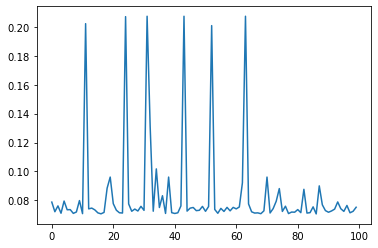

크기 1428296
비정상 489
[1.6352006  0.6352006  0.6352005  ... 0.07053187 0.07053183 0.07052669]


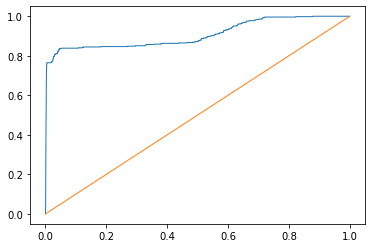

0.9073745550405578


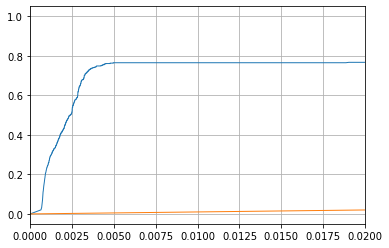

1%
fpr: 0.005478331455161657
tpr:  0.7648261758691206

374 1419985 7822 115
precision:  0.04563201561737433
recall:  0.7648261758691206
F-measure: 0.08612550374208405
MCC: 0.18598139838541095
0.5%
fpr: 0.004965657123126585
tpr:  0.7648261758691206

374 1420717 7090 115
precision:  0.05010718113612004
recall:  0.7648261758691206
F-measure: 0.09405255878284925
MCC: 0.194969142907764
0.1%
fpr: 0.0009966332984780155
tpr:  0.23517382413087934

115 1426384 1423 374
precision:  0.07477243172951886
recall:  0.23517382413087934
F-measure: 0.11346817957572768
MCC: 0.13209319627747007


In [4]:


l2param = 0.03
print("l2param =", l2param)
model = keras.Sequential(
  [
    layers.Dense(128, activation="sigmoid",
                 kernel_regularizer=tf.keras.regularizers.l2(l2param)),
    #layers.Dropout(0.25),
    layers.Dense(32, activation="sigmoid",
                 kernel_regularizer=tf.keras.regularizers.l2(l2param)),
    #layers.Dropout(0.25),
    layers.Dense(2, activation="sigmoid",
                 kernel_regularizer=tf.keras.regularizers.l2(l2param))
  ]
)
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0005), metrics=['accuracy'])




model.fit(training_set, epochs=10, verbose=1)


print(sum(model(normal.iloc[:100,1:].loc[:, feature].astype('float64').to_numpy())[:,1] ))
print(sum(model(abnormal.iloc[:100,1:].loc[:, feature].astype('float64').to_numpy())[:,1] ))



result = model.predict(test_set)[:, 1]

plt.figure()
plt.plot(result[:100])
plt.show()
new_label = test_y[:,1]
#new_label = 1-label
#new_label = label.astype(np.int)

#print(result[1500:1600])
#print(new_label[1500:1600])


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



print('크기', len(new_label))
print('비정상', sum(new_label))
fpr, tpr, thesholds = roc_curve(new_label, result)
print(thesholds)
plt.figure()
plt.plot(fpr, tpr, lw=1)
mean_fpr = np.linspace(0, 1, 100)
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()
print(auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr, lw=1)

mean_fpr = np.linspace(0, 1, 100)
plt.xlim([0, 0.02])
plt.grid("on")
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()

print("1%")
for i in range(len(fpr)):
  if fpr[i] > 0.01: #1%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))

print("0.5%")
for i in range(len(fpr)):
  if fpr[i] > 0.005: #0.5%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))

print("0.1%")
for i in range(len(fpr)):
  if fpr[i] > 0.001: #0.1%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))


In [7]:

import pickle
data_dictionary = {}
data_dictionary['result'] = result
data_dictionary['new_label'] = new_label

with open("MLP_DICT.pck", "wb") as file:
  pickle.dump(data_dictionary, file)
  





크기 1428296
비정상 489
[1.6347098  0.63470984 0.6347097  ... 0.07210768 0.07210766 0.07210764]


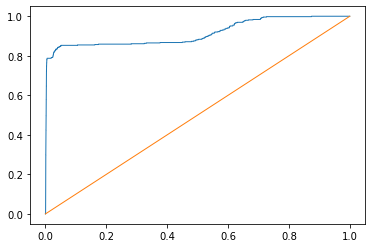

0.9142003645864604


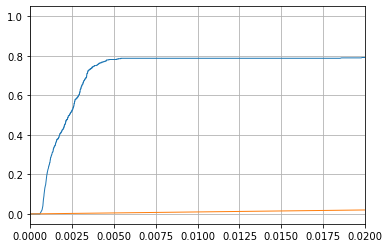

1%
fpr: 0.005574282798725598
tpr:  0.787321063394683

385 1419848 7959 104
precision:  0.04614093959731544
recall:  0.787321063394683
F-measure: 0.08717310087173101
MCC: 0.18977163738200814
0.5%
fpr: 0.004862702031857247
tpr:  0.7811860940695297

382 1420864 6943 107
precision:  0.05215017064846417
recall:  0.7811860940695297
F-measure: 0.09777322754031226
MCC: 0.2010645163596606
0.1%
fpr: 0.0009945321741663964
tpr:  0.1983640081799591

97 1426387 1420 392
precision:  0.06394199077125906
recall:  0.1983640081799591
F-measure: 0.0967098703888335
MCC: 0.11209804187154244


In [1]:
#load_data
import pickle

with open("MLP_DICT.pck", "rb") as file:
  data_dictionary = pickle.load(file)
result = data_dictionary['result']
new_label = data_dictionary['new_label']

import itertools
import pandas as pd
import glob
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import scale
from sklearn import mixture
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



print('크기', len(new_label))
print('비정상', sum(new_label))
fpr, tpr, thesholds = roc_curve(new_label, result)
print(thesholds)
plt.figure()
plt.plot(fpr, tpr, lw=1)
mean_fpr = np.linspace(0, 1, 100)
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()
print(auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr, lw=1)

mean_fpr = np.linspace(0, 1, 100)
plt.xlim([0, 0.02])
plt.grid("on")
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()

print("1%")
for i in range(len(fpr)):
  if fpr[i] > 0.01: #1%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))

print("0.5%")
for i in range(len(fpr)):
  if fpr[i] > 0.005: #0.5%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))

print("0.1%")
for i in range(len(fpr)):
  if fpr[i] > 0.001: #0.1%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

133000
133100
133200
133300
133400
133500
133600
133700
133800
133900
134000
134100
134200
134300
134400
134500
134600
134700
134800
134900
135000
135100
135200
135300
135400
135500
135600
135700
135800
135900
136000
136100
136200
136300
136400
136500
136600
136700
136800
136900
137000
137100
137200
137300
137400
137500
137600
137700
137800
137900
138000
138100
138200
138300
138400
138500
138600
138700
138800
138900
139000
139100
139200
139300
139400
139500
139600
139700
139800
139900
140000
140100
140200
140300
140400
140500
140600
140700
140800
140900
141000
141100
141200
141300
141400
141500
141600
141700
141800
141900
142000
142100
142200
142300
142400
142500
142600
142700
142800
142900
143000
143100
143200
143300
143400
143500
143600
143700
143800
143900
144000
144100
144200
144300
144400
144500
144600
144700
144800
144900
145000
145100
145200
145300
145400
145500
145600
145700
145800
145900
146000
146100
146200
146300
146400
146500
146600
146700
146800
146900
147000
147100
147200

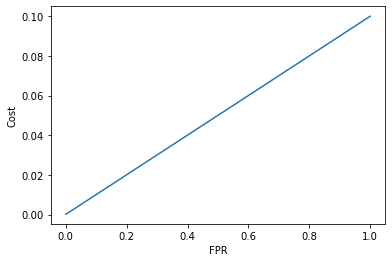

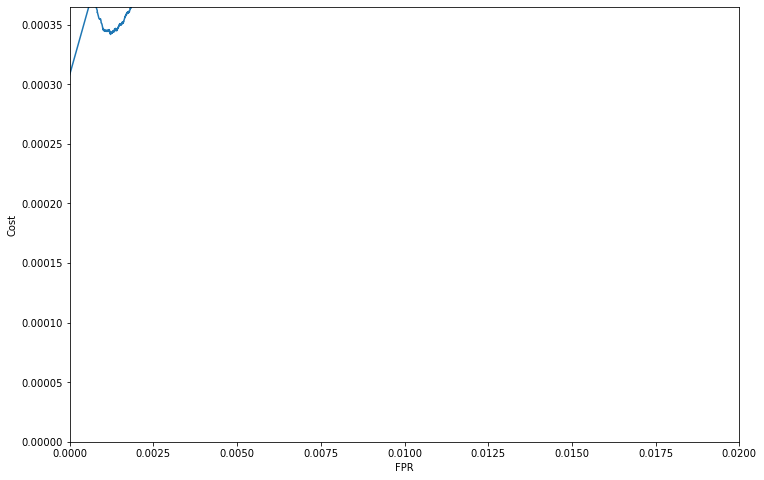

0.0
0.00030812940734973703


In [2]:

#총 데이터 중 정상 데이터 비율
normal_n = 2855614
#총 데이터중 비정상 데이터 비율
abnormal_n = 978

p_plus = abnormal_n/(normal_n+abnormal_n)
p_minus = normal_n/(normal_n+abnormal_n)

w_FNR = 0.9
w_FPR = 0.1

cost = []
for i in range(len(fpr)):
  if i % 100 == 0:
    print(i)
  predicted = result >= thesholds[i]
  TP = np.sum(np.logical_and(new_label==1,  predicted==1))
  TN = np.sum(np.logical_and(new_label==0,  predicted==0))
  FP = np.sum(np.logical_and(new_label==0,  predicted==1))
  FN = np.sum(np.logical_and(new_label==1,  predicted==0))
  FNR = FN/(FN+TP) #비정상 데이터중 미알람 비율
  FPR = FP/(FP+TN) #정상 데이터중 비정상 알람 비율
  
  cost.append(w_FNR*FNR*p_plus + w_FPR*FPR*p_minus)


plt.plot(fpr, cost)
plt.xlabel("FPR")
plt.ylabel("Cost")
plt.show()

plt.figure(figsize=[12, 8])
plt.plot(fpr, cost)
plt.xlabel("FPR")
plt.ylabel("Cost")
plt.xlim([0, 0.02])
plt.ylim([0, cost[400]])
plt.show()

print(fpr[np.argmin(cost)])
print(np.amin(cost))